# Argumentation:

We would like to build a risk management strategy based on our expectation of future losses. We know we have volatility cluster in the log-returns, thus, we want to be able to predict tail loss and deinvest in such periods.


- Value-At-Risk (baseline, HVaR): a first simple estimation is based on a historical window. The pbl of such approach is that it assumes stationarity, thus does not take into consideration volatility clusters, we will be overshooting (in period of low volatility) or undershooting (in period of high volatility) the risk.

- GARCH estimation (GVaR): we predict next hour volatility and base our VaR estimation on this prediction. If GVaR is lower than HVaR, risk is high we deinvest, if GVaR is higher risk is low.

- DL prediction: we predict if returns is lower or higher than HVaR.


Idea: risk build up strategy from Packam with binary classifier of DL.



Parameter of binary classifier:
- quantile, q: fixed
- lookback to estimate q


In [1]:
import pandas as pd

import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

# label
def labelQuantile(close,
                  lq = 0.1,
                  uq = 0.9,
                  lookfront = 1,
                  window = 30,
                  threshold = None,
                  log = False,
                  fee = 0,
                  binary = False):
    """

    :param close: numpy, close price
    :param lq: float, lower quantile
    :param uq: float, upper quantile
    :param lookfront: int, horizon forecast
    :param window: int, rolling window size for computing the quantile
    :param log: boolean, log scale or simple
    :param fee: float, fee
    :param binary: boolean, output is two classes or three classes
    :return:
    """

    hist_returns = np.zeros(len(close), dtype=float)

    if log:
        hist_returns[1:] = np.log(close[1:]/close[0:-1])
    else:
        hist_returns[1:] = close[1:]/close[0:-1] - 1

    labels = np.zeros(len(close), dtype=int)
    returns = np.zeros(len(close), dtype=float)

    lower_q = np.zeros(len(close), dtype=float)
    upper_q = np.zeros(len(close), dtype=float)

    for t in range(window, len(close) - lookfront):
        data_w = hist_returns[t-window : t]

        if threshold is not None:
            losses = data_w[data_w < -threshold]
            gains = data_w[data_w >= threshold]
            lower_q_t = np.quantile(losses, lq)
            upper_q_t = np.quantile(gains, uq)
        else:
            lower_q_t = np.quantile(data_w, lq) # rolling = returns.rolling(window) q10 = rolling.quantile(0.1)
            upper_q_t = np.quantile(data_w, uq)

        for i in range(1, lookfront +1):
            ratio = hist_returns[t + i]
            if ratio <= lower_q_t:
                if binary:
                    labels[t] = 1
                else:
                    labels[t] = 2
                break
            elif ratio >= upper_q_t:
                labels[t] = 1
                break

        returns[t] = hist_returns[t + i]
        lower_q[t] = lower_q_t
        upper_q[t] = upper_q_t

    quantiles = np.concatenate([lower_q.reshape(-1,1),
                                upper_q.reshape(-1,1)],
                               axis = 1)

    return labels, returns, quantiles

# data
def load_data(path='../data/btc_1H_20160101_20190101.csv', features=['ROCP_1'], label = 'labelPeakOverThreshold', **kwargs_label):
    """
    load raw data, build features and target
    :param path: str, path to data source
    :param features: list, features names
    :param kwargs_label: dict, parameter of labelling function
    :return: dfdata (pandas.DataFrame), target (str)
    """

    dfdata = pd.read_csv(path, index_col=0)
    dfdata.index = pd.to_datetime(dfdata.index)
    dfdata = dfdata.dropna()
    dfdata = dfdata.astype(np.float64)
    target = 'btc_usdt'

    # load label
    if label == 'labelPeakOverThreshold':
        npLabels = labelPeakOverThreshold(dfdata.close, **kwargs_label)
        labels = pd.DataFrame(npLabels,
                              columns=[target],
                              index=dfdata.index)
        dfdata['target'] = labels[target].values



    if label == 'labelQuantile':
        npLabels, label_returns, quantiles = labelQuantile(dfdata.close.values, **kwargs_label)
        # dflabel = pd.DataFrame(index = dfdata.index)
        dfdata['target'] = npLabels
        dfdata['returns'] = label_returns
        dfdata['lower'] = quantiles[:,0]
        dfdata['upper'] = quantiles[:,1]



    # load_features
    if features is not None:
        if features == ['ROCP_1']:
            feature = dfdata[['close']].pct_change()
            feature.columns = features

        elif features == ['log_ROCP_1']:
            feature = np.log(dfdata[['close']].pct_change() + 1)
            feature.columns = features

        dfdata = pd.concat([dfdata, feature], axis=1)

    target = 'target'

    return dfdata, target

def sharpe_ratio(returns, period):
    return returns.mean()/returns.std() * np.sqrt(period)


In [5]:
hour = 1
day = 24
month = 30 * day

results = {}

for window in [hour, day, month, 2*month, 3*month, 4*month, 5*month, 6*month, 12*month]:
    print(window)
    dfdata, target = load_data(path='../../data/btc_1H_20160101_20190101.csv',
    features=None, 
    label = 'labelQuantile',
    window = window,
    log = True,
    binary = False)

    dfdata['signal'] = 1 
    dfdata.loc[dfdata['target'] == 2, 'signal'] = 0
    dfdata['perf'] = dfdata['signal'] * dfdata['returns']
    cum_returns = dfdata['perf'].cumsum().values[-1]
    sr = sharpe_ratio(dfdata['perf'], period = 24*365)
    
    results[window] = [cum_returns, sr]
    
    print(results[window])

1
[59.90559557307268, 32.601771727229135]
24
[46.29736176399334, 21.92861927780007]
720
[44.27846939709145, 21.768988163080852]
1440
[43.45066981129844, 21.801764133113092]
2160
[43.49082761871735, 22.19172662312349]
2880
[43.46637090913714, 22.352131138037144]
3600
[42.9405603677546, 22.28924428059418]
4320
[40.93350435388855, 21.78363442931781]
8640
[39.123016356167206, 21.672064848491775]


In [17]:
window = 2880
dfdata, target = load_data(path='../../data/btc_1H_20160101_20190101.csv',
features=None, 
label = 'labelQuantile',
window = window,
log = True,
binary = False)

dfdata['signal'] = 1 
dfdata.loc[dfdata['target'] == 2, 'signal'] = 0
dfdata['perf'] = dfdata['signal'] * dfdata['returns']
cum_returns = dfdata['perf'].cumsum().values[-1]
sr = sharpe_ratio(dfdata['perf'], period = 24*365)

Exceedance:  0.10322745901639344


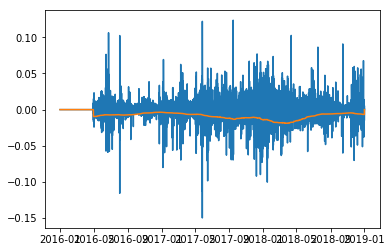

In [18]:
plt.plot(dfdata['returns'])
plt.plot(dfdata['lower'])
print('Exceedance: ', (dfdata['target'][dfdata['lower'] < 0] == 2).sum()/len(dfdata[dfdata['lower'] < 0]))

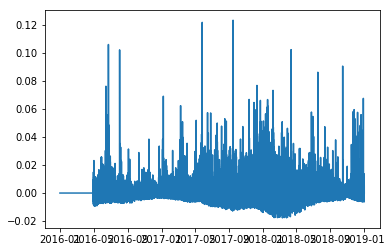

In [20]:
plt.plot(dfdata['perf'])

# Parameters

In [3]:
dir_  = '..''/saved_models_01082019/30072019-085812-labelQuantile_cv_10_window_720_epoch_100_log_class_weighted/'

dfdata = pickle.load(open(dir_ + 'dfdata.p', 'rb'))
cvdates = json.load(open('%s/global_dates.json' % dir_, 'r'))

epoch_number = 60
n_epochs = 100

ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package

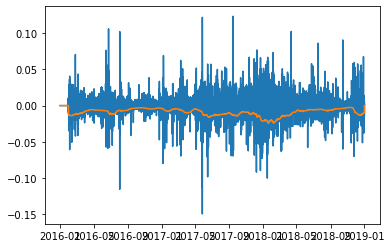

In [23]:
plt.plot(dfdata['returns'])
plt.plot(dfdata['lower'])



In [24]:
(dfdata['target'][dfdata['lower'] < 0] == 2).sum()/len(dfdata[dfdata['lower'] < 0])

0.10053158223889931

In [16]:
np.log(dfdata['close'].shift(-1)/dfdata['close'])[dfdata['lower'] < 0]

2016-01-02 00:00:00    0.007215
2016-01-02 01:00:00    0.000000
2016-01-02 02:00:00   -0.017591
2016-01-02 03:00:00    0.001973
2016-01-02 04:00:00    0.002015
2016-01-02 05:00:00    0.000000
2016-01-02 06:00:00    0.000000
2016-01-02 07:00:00    0.000000
2016-01-02 08:00:00    0.000000
2016-01-02 09:00:00    0.000624
2016-01-02 10:00:00    0.000000
2016-01-02 11:00:00    0.000023
2016-01-02 12:00:00    0.000000
2016-01-02 13:00:00    0.000000
2016-01-02 14:00:00   -0.000046
2016-01-02 15:00:00    0.000000
2016-01-02 16:00:00    0.000000
2016-01-02 17:00:00   -0.000601
2016-01-02 18:00:00    0.000000
2016-01-02 19:00:00    0.000000
2016-01-02 20:00:00    0.000000
2016-01-02 21:00:00    0.010884
2016-01-02 22:00:00    0.000000
2016-01-02 23:00:00    0.000000
2016-01-03 00:00:00    0.000000
2016-01-03 01:00:00    0.000000
2016-01-03 02:00:00   -0.003060
2016-01-03 03:00:00   -0.011835
2016-01-03 04:00:00    0.000000
2016-01-03 05:00:00    0.010714
                         ...   
2018-12-

In [9]:
dfdata[dfdata['lower'] > dfdata['returns']]

,open,high,low,close,volume,target,returns,lower,upper,log_ROCP_1
2016-01-02 02:00:00,438.140000,438.140000,438.140000,438.140000,0.000000,2,-0.017591,-5.144460e-03,0.007078,0.000000e+00
2016-01-03 02:00:00,436.949900,436.949900,436.949900,436.949900,0.000000,2,-0.003060,-3.237069e-05,0.001568,0.000000e+00
2016-01-03 03:00:00,432.310000,435.614998,432.310000,435.614998,7.644967,2,-0.011835,-3.237069e-05,0.001568,-3.059722e-03
2016-01-03 08:00:00,435.127280,435.127280,435.127280,435.127280,0.000000,2,-0.020136,-4.348284e-04,0.000444,0.000000e+00
2016-01-03 11:00:00,429.000000,429.000000,429.000000,429.000000,0.000000,2,-0.003971,-2.322214e-03,0.004175,0.000000e+00
2016-01-03 14:00:00,427.300000,429.860000,427.300000,429.000000,4.942737,2,-0.003971,-3.697320e-03,0.004168,3.970576e-03
2016-01-04 08:00:00,429.569500,435.679577,429.569500,435.679577,204.261278,2,-0.014122,-3.368574e-03,0.003379,1.412351e-02
2016-01-04 14:00:00,429.999751,435.544163,429.999751,430.430000,11.828233,2,-0.002001,-1.674533e-03,0.003379,1.000081e-03
2016-01-04 17:00:00,435.999999,435.999999,435.999999,435.999999,0.000000,2,-0.011535,-1.674533e-03,0.003608,0.000000e+00
2016-01-04 19:00:00,430.999616,430.999719,430.999616,430.999719,0.431000,2,-0.001997,-1.989986e-03,0.003608,2.388633e-07


# AUC score

[0 1 2 3 4 5 6 7 8 9]
CV 0
Optimal proba:  0.39358246
CV 1
Optimal proba:  0.4105071
CV 2
Optimal proba:  0.39184496
CV 3
Optimal proba:  0.38326758
CV 4
Optimal proba:  0.34716582
CV 5
Optimal proba:  0.36668754
CV 6
Optimal proba:  0.4013841
CV 7
Optimal proba:  0.38127524
CV 8
Optimal proba:  0.41609743
CV 9
Optimal proba:  0.42625752
[[5638 1247]
 [ 729  276]]
EXCEEDANCES: 0.09
              precision    recall  f1-score   support

           0       0.89      0.82      0.85      6885
           1       0.18      0.27      0.22      1005

   micro avg       0.75      0.75      0.75      7890
   macro avg       0.53      0.55      0.53      7890
weighted avg       0.80      0.75      0.77      7890



/Users/brunospilak/miniconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


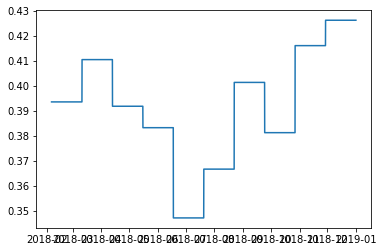

In [3]:
window = 24*30*12 * 2 # find optimal on last window of 2 years
func = 'get_optimal_t_from_auc'
probas = None
level = None
type_ = None

train_pred_auc, dl_pred_auc = get_pred_from_train(dir_, epoch_number, n_epochs, window,
                                          func = func, probas = probas, level = level, type_ = type_)

plt.plot(dl_pred_auc['probas'])
cm3 = metrics.confusion_matrix(dl_pred_auc['target_drop'], dl_pred_auc['pred_drop'])
print(cm3)
print('EXCEEDANCES: %s' % round((cm3[1,0]/np.sum(cm3)), 2))
print(metrics.classification_report(dl_pred_auc['target_drop'], dl_pred_auc['pred_drop']))